<a href="https://colab.research.google.com/github/julicq/terminators/blob/main/Terminators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastbook

In [2]:
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', '98548fb8bfee4ea1afb40b247e3f3a15')

In [5]:
search_images_bing

<function fastbook.search_images_bing>

In [18]:
results = search_images_bing(key, 'terminator')
ims = results.attrgot('contentUrl')
len(ims)

150

In [21]:
ims[0]

'http://allhdwallpapers.com/wp-content/uploads/2015/04/the-terminator-6.jpg'

In [22]:
ims = ['http://allhdwallpapers.com/wp-content/uploads/2015/04/the-terminator-6.jpg']

In [23]:
dest = 'images/terminator.jpg'
download_url(ims[0], dest)

Path('images/terminator.jpg')

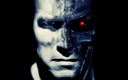

In [24]:
im = Image.open(dest)
im.to_thumb(128,128)

In [25]:
terminators = 'T-800','T-1000'
path = Path('terminators')

In [26]:
if not path.exists():
    path.mkdir()
    for o in terminators:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} terminator')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [27]:
fns = get_image_files(path)
fns

(#0) []

In [ ]:
failed = verify_images(fns)
failed

In [ ]:
failed.map(Path.unlink);

In [ ]:
terminators = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [ ]:
dls = terminators.dataloaders(path)

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
terminators = terminators.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = terminators.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
terminators = terminators.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = terminators.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
terminators = terminators.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = terminators.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
terminators = terminators.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = terminators.dataloaders(path)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.predict('images/terminator.jpg')

In [ ]:
learn_inf.dls.vocab

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

In [ ]:
btn_upload = SimpleNamespace(data = ['images/terminator.jpg'])

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your terminator!'), 
      btn_upload, btn_run, out_pl, lbl_pred])